In [35]:
from keras import applications
# python image_scraper.py  "yellow labrador retriever" --count 500 --label labrador
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback


from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import (Dropout, Flatten, Dense, Conv2D, 
                          Activation, MaxPooling2D)

from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras import backend as K

from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import os, glob
from tqdm import tqdm
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import shutil

In [12]:
more_im = glob.glob("collie_lab/*/*.jpg")
more_im = shuffle(more_im)
collie = [x for x in more_im if "coll" in x.split("\\")[-2]]
lab = [x for x in shuffle(more_im) if "lab" in x.split("\\")[-2]]

print(len(collie))
print(len(lab))

for_labeling = collie + lab
for_labeling = shuffle(for_labeling)

Counter([x.split("\\")[-2] for x in more_im]).most_common()

600
596


[('collie', 600), ('labrador', 596)]

In [18]:
import shutil
from tqdm import tqdm

%mkdir collie_lab_train
%mkdir collie_lab_valid

%mkdir collie_lab_train\\collie
%mkdir collie_lab_train\\lab

%mkdir collie_lab_valid\\collie
%mkdir collie_lab_valid\\lab


for index, image in tqdm(enumerate(for_labeling)):
    
    if index < 1000:
        label = image.split("\\")[-2]
        image_name = image.split("\\")[-1]
        if "coll" in label:
            shutil.copy(image, 'collie_lab_train\\collie\\{}'.format(image_name))
        if "lab" in label:
            shutil.copy(image, 'collie_lab_train\\lab\\{}'.format(image_name))
            
    if index > 1000:
        label = image.split("\\")[-2]
        image_name = image.split("\\")[-1]
        if "coll" in label:
            shutil.copy(image, 'collie_lab_valid\\collie\\{}'.format(image_name))
        if "lab" in label:
            shutil.copy(image, 'collie_lab_valid\\lab\\{}'.format(image_name))   

A subdirectory or file collie_lab_train already exists.
A subdirectory or file collie_lab_valid already exists.
1196it [00:04, 244.83it/s]


In [2]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)


test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    'collie_lab_train/',
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    'collie_lab_valid/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


In [3]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu')) #tanh
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu')) #tanh
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(96))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1)) # binary
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [4]:
model.fit_generator(
    train_generator,
    steps_per_epoch= 3000 // 32, # give me more data
    epochs=30,
    callbacks=[TQDMNotebookCallback()],
    verbose=0,
    validation_data=validation_generator,
    validation_steps= 300 // 32)

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

validation_generator = test_datagen.flow_from_directory(
    'collie_lab_valid/',
    target_size=(150, 150),
    batch_size=1, shuffle=False,
    class_mode='binary')


preds = model.predict_generator(generator=validation_generator, steps=195)

Found 195 images belonging to 2 classes.


In [47]:
def load_an_image(file_name):
    img = image.load_img(

        os.path.join(os.getcwd() + '\\collie_lab_valid\\',  file_name)
       , 
        target_size=(224, 224)

    )
    return img

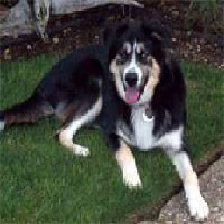

In [50]:
load_an_image(validation_generator.filenames[3])

In [55]:
confusion_matrix(validation_generator.classes, [np.round(x) for x in preds])

array([[92,  9],
       [13, 81]])

In [56]:
validation_generator.class_indices

{'collie': 0, 'lab': 1}

In [63]:
bad_indices = []

for index, pair in enumerate(list(zip(validation_generator.classes, 
                                   [int(np.round(x)[0]) for x in preds]))):
    
    if pair[0] != pair[1]:
        bad_indices.append(index)
        

In [65]:
bad_indices

[1,
 9,
 12,
 19,
 26,
 32,
 48,
 63,
 84,
 105,
 122,
 123,
 124,
 153,
 159,
 161,
 162,
 165,
 168,
 176,
 177,
 189]

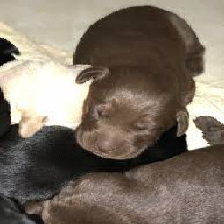

In [72]:
load_an_image(validation_generator.filenames[161])